In [1]:
import pandas as pd 
from pandas import Series
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.api import qqplot  
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 

import pmdarima as pm
from pmdarima import auto_arima 
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn import datasets

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
#Importing data
Guangzhou = pd.read_csv("D:/Math546 Time series/final projects/PM2.5 Data of Five Chinese Cities Data Set/GuangzhouPM20100101_20151231.csv")


In [3]:
#Delet non-useful data
##Beijing.drop(['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'season', 'precipitation', 'Iprec'], 
##               axis=1,
##              inplace=True)

In [4]:
Guangzhou.dropna(axis=0, how="any",inplace=True)

In [5]:
# from datetime import datetime
Guangzhou['Time'] = pd.to_datetime(Guangzhou['year'].map(str) +"/"+ Guangzhou['month'].map(str) +"/"+ Guangzhou['day'].map(str)+" "+Guangzhou['hour'].map(str)+":00:00")
#Beijing

In [6]:
Guangzhou.groupby(['year']).size()

year
2013    3863
2014    7884
2015    8327
dtype: int64

In [8]:
by_hour = Guangzhou.groupby(['Time']).mean()
#by_hour.head()

In [9]:
by_hour.index = pd.to_datetime(by_hour.index, 
                             format='%d-%m-%Y %H:%M:%S')
by_hour = by_hour.set_index(by_hour.index).asfreq('H')
by_hour = by_hour.fillna(method='ffill')

#print(by_hour.index)

In [10]:
by_hour['Time'] = by_hour.index
#by_hour['Time']

In [11]:
data_13 = by_hour[(by_hour['Time'] >=pd.to_datetime('20140101030000')) & (by_hour['Time'] <= pd.to_datetime('20151231030000'))]

In [12]:
data_13 = data_13.set_index(data_13.index).asfreq('d')
data_13 = data_13.fillna(method='ffill')
#data_13

In [13]:
#data_13.to_csv(r'D:/Math546 Time series/project/Prep_FiveCitiePMData_MEAN/GuangzhouPM_cleaned.csv')

In [14]:
data = by_hour[(by_hour['Time'] >=pd.to_datetime('20140101030000')) & (by_hour['Time'] <= pd.to_datetime('20140201030000'))]
data = data.set_index(data.index).asfreq('d')
data = data.fillna(method='ffill')
#data

In [15]:
# take aDFuller test the statioinarity of  the timeseries
def test_stationarity(timeseries):
 #Determing rolling statistics
    rolmean=pd.Series.rolling(timeseries,window=12).mean()
 #rolmean=pd.rolling_mean(timeseries,window=12)
 #rolstd=pd.rolling_std(timeseries,window=12)
    rolstd=pd.Series.rolling(timeseries,window=12).std()
 
 #plot rolling statistics
    orig=plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(rolmean,color='red',label='Rolling mean')
    std=plt.plot(rolstd,color='black',label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean & Standard Deviatiom')
    plt.show(block=False)
 
 #perfprmance Dickey_Fuller Test
    print('Resluts of Dickey-Fuller Test:')
    dftest=adfuller(timeseries,autolag='AIC')
    dfountput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','Number of obervations used'])
 
    for key,value in dftest[4].items():
        dfountput['Critical Value(%s)'%key]=value      
    print(dfountput)
# 

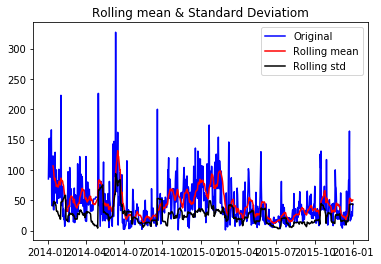

Resluts of Dickey-Fuller Test:
Test Statistic                 -5.065574
p-value                         0.000016
#lags used                     11.000000
Number of obervations used    718.000000
Critical Value(1%)             -3.439490
Critical Value(5%)             -2.865574
Critical Value(10%)            -2.568918
dtype: float64


In [16]:
test_stationarity(data_13['PM_US Post'])

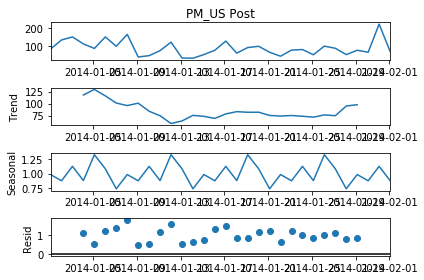

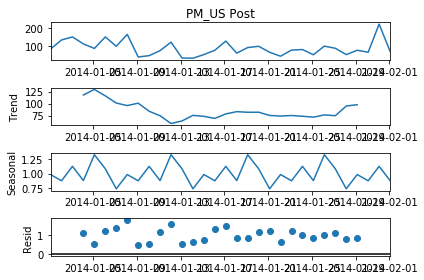

In [17]:
result = seasonal_decompose(data['PM_US Post'],  
                            model ='multiplicative') 
  
# ETS plot  
result.plot()

In [18]:
len(data_13)

730

In [19]:
# Split data into train / test sets 
train = data_13['PM_US Post'].iloc[:len(data_13)-156] 
test = data_13['PM_US Post'].iloc[len(data_13)-156:]

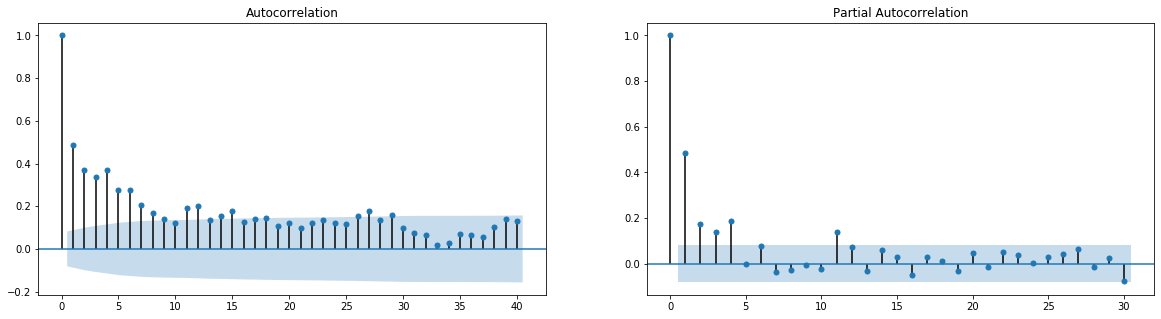

In [20]:
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_acf(train, lags=40, ax=axes[0], fft=False)
plot_pacf(train, lags=30, ax=axes[1])
plt.show()

In [21]:
# Fit auto_arima function to dataset 
stepwise_fit = auto_arima(train, start_p = 0, start_q = 0, 
                          max_p = 4, max_q = 8, m=52,
                          start_P = 0, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise  

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 52) (constant=True); AIC=5408.839, BIC=5421.612, Time=22.913 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=True); AIC=5636.656, BIC=5645.171, Time=0.465 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 52) (constant=True); AIC=5385.891, BIC=5402.921, Time=20.314 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 52) (constant=True); AIC=5307.957, BIC=5324.988, Time=30.397 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=False); AIC=5639.716, BIC=5643.973, Time=0.461 seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 0, 52) (constant=True); AIC=5518.251, BIC=5531.024, Time=5.193 seconds
Fit ARIMA: (1, 0, 0)x(2, 1, 0, 52) (constant=True); AIC=5329.821, BIC=5351.110, Time=117.606 seconds
Fit ARIMA: (1, 0, 0)x(2, 1, 1, 52) (constant=True); AIC=5268.628, BIC=5294.174, Time=136.255 second

In [22]:
# To print the summary 
stepwise_fit.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  574
Model:             SARIMAX(1, 0, 2)x(1, 1, [1], 52)   Log Likelihood               -2610.866
Date:                              Tue, 14 Apr 2020   AIC                           5235.733
Time:                                      18:56:58   BIC                           5265.536
Sample:                                           0   HQIC                          5247.406
                                              - 574                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2660      0.184     -1.449      0.147      -0.626       0.094
ar.L1          0.9149      0.034     26.562      0.000       0.847       0.982
ma.L1         -0.5414      0.053    -10.260      0.000      -0.645      -0.438
ma.L2         -0.1224      0.045     -2.705      0.007      -0.211      -0.034
ar.S.L52      -0.0478      0.047     -1.024      0.306      -0.139       0.044
ma.S.L52      -0.9944      2.064     -0.482      0.630      -5.040       3.051
sigma2      1015.0310   2069.992      0.490      0.624   -3042.078    5072.140
===================================================================================
Ljung-Box (Q):                       60.75   Jarque-Bera (JB):               406.31
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                             0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
# Fit a SARIMAX(1, 0, 2)x(1, 1, [1], 52)on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train,  
                order = (1, 0, 2),  
                seasonal_order =(1, 1, [1], 52))

In [24]:
result = model.fit() 

In [25]:
 result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           PM_US Post   No. Observations:                  574
Model:             SARIMAX(1, 0, 2)x(1, 1, [1], 52)   Log Likelihood               -2612.608
Date:                              Tue, 14 Apr 2020   AIC                           5237.215
Time:                                      19:00:48   BIC                           5262.761
Sample:                                  01-01-2014   HQIC                          5247.221
                                       - 07-28-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9297      0.031     30.018      0.000       0.869       0.990
ma.L1         -0.5501      0.049    -11.267      0.000      -0.646      -0.454
ma.L2         -0.1278      0.044     -2.905      0.004      -0.214      -0.042
ar.S.L52      -0.0481      0.046     -1.050      0.294      -0.138       0.042
ma.S.L52      -0.9908      1.212     -0.817      0.414      -3.367       1.385
sigma2      1024.7877   1217.981      0.841      0.400   -1362.410    3411.986
===================================================================================
Ljung-Box (Q):                       62.08   Jarque-Bera (JB):               412.90
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

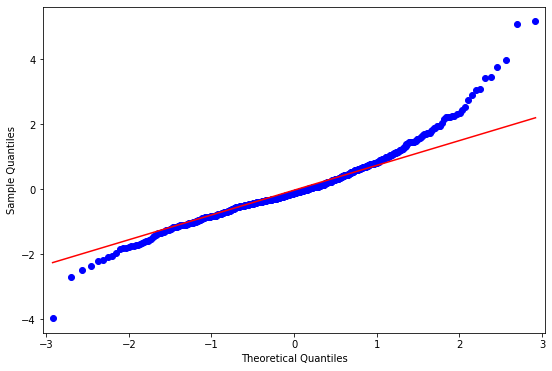

In [26]:
resid = result.resid
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

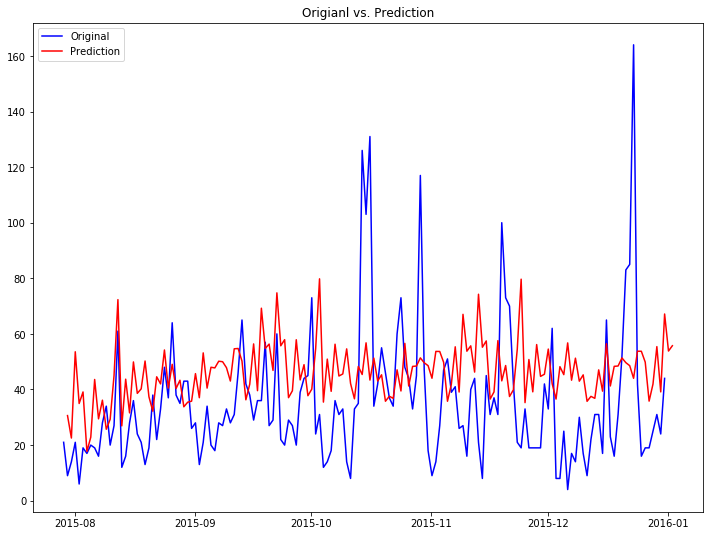

In [27]:
predict_ARMA = result.predict(start =575, end = 731) 
#print(predict_ARIMA) 

plt.figure(figsize=(12,9)) 
orig = plt.plot(test, color='blue', label='Original') 
pred = plt.plot(predict_ARMA, color='red', label='Prediction' ) 
plt.legend(loc='best') 
plt.title('Origianl vs. Prediction') 
plt.show(block=False) 